# Initialization

In [1]:
import os
import grasp
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')

try:
    device_name = os.getenv('COMPUTERNAME')
    if device_name == 'DESKTOP-Work':
        tn1 = '20250506_170539'
        tn2 = '20250506_170541'
        tn3 = '20250508_172350'
        acs = grasp.load_data(tn = tn1)
        pcs = grasp.load_data(tn = tn2)
        fas = grasp.load_data(tn = tn3)
    elif device_name == 'LAPTOP-Work':
        tn1 = '20250401_164228'
        tn2 = '20250401_164231'
        tn3 = '20250414_095328'
        pcs = grasp.load_data(tn = tn1)
        acs = grasp.load_data(tn = tn2)
        fas = grasp.load_data(tn = tn3)
    else:
        raise EnvironmentError("Unknown device name")
    acs.gc = pcs.gc = fas.gc = gc
except FileNotFoundError as e:
    print(e)
    astrometry_query = "SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                        radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND abs(parallax_error/parallax)<0.50\
                        AND abs(pmra_error/pmra)<0.30 \
                        AND abs(pmdec_error/pmdec)<0.30 \
                        AND pmra IS NOT NULL AND abs(pmra)>0 \
                        AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.214805 AND -17.807517"
    
    photometry_query = "SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                        bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND ruwe < 1.15 \
                        AND phot_g_mean_mag > 11 \
                        AND astrometric_excess_noise_sig < 2 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.2148 AND -17.807517"
    acs = dr3.free_query(astrometry_query, save=True)
    acs = grasp.Sample(acs, gc)
    pcs = dr3.free_query(photometry_query, save=True)
    pcs = grasp.Sample(pcs, gc)
    fas = dr3.get_astrometry(0.86, 'ngc6121', save=True)
    print("\nWARNING! Remember to updates tn after running the new query!!!")


            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'
Not a Cluster: no model available
Not a Cluster: no model available


In [2]:
aps = acs.join(pcs)
aps.gc.dist = 1851 * u.pc # Baumgardt, Vasiliev: 2021 # pc
f = grasp.load_base_formulary()
aps.info()

<Sample length=1014>
          name            dtype     class     n_bad
------------------------ ------- ------------ -----
               SOURCE_ID   int64       Column     0
                      ra float64       Column     0
                ra_error float32       Column     0
                     dec float64       Column     0
               dec_error float32       Column     0
                parallax float64       Column     0
          parallax_error float32       Column     0
                    pmra float64       Column     0
              pmra_error float32       Column     0
                   pmdec float64       Column     0
             pmdec_error float32       Column     0
         radial_velocity float32 MaskedColumn   923
   radial_velocity_error float32 MaskedColumn   923
                   bp_rp float32 MaskedColumn    31
         phot_g_mean_mag float32 MaskedColumn     1
        phot_bp_mean_mag float32 MaskedColumn   118
        phot_rp_mean_mag float32 MaskedColu

# Data visualization

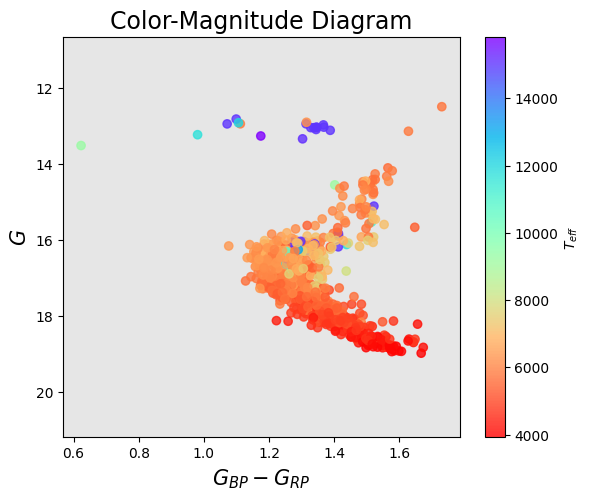

In [3]:
grasp.plots.colorMagnitude(aps)

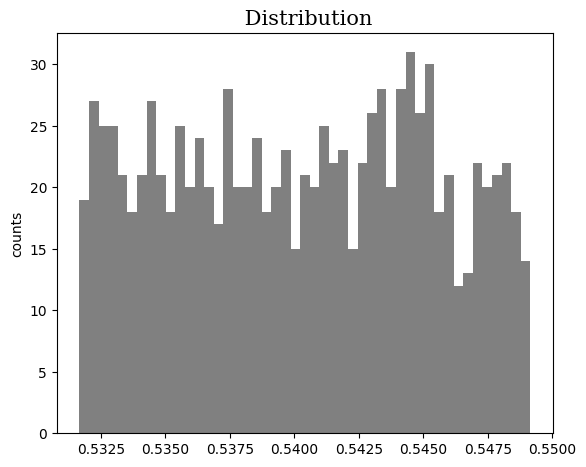

In [4]:
grasp.plots.histogram(aps.parallax, bins='detailed')

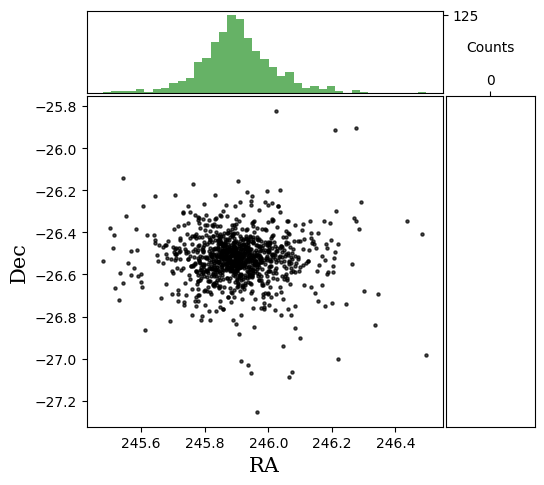

In [5]:
grasp.plots.doubleHistScatter(aps.ra, aps.dec, xlabel='RA', ylabel='Dec')

# Angular Separation Analysis

The `Great Circle` formula versus the `Vincenty Formula` for the computation of distances on a sphere

### $\theta_V$ vs $\theta_{GC}$ vs $\theta_{G}$

In [6]:
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.to(u.rad).value, 'delta_{0}':aps.gc.dec.to(u.rad).value})

from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1) * sin((alpha_0 - alpha_1)/2))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.to(u.rad).value, 'delta_0':aps.gc.dec.to(u.rad).value})


f.angular_separation

Eq(theta, 2*asin(sqrt(0.894734909182543*sin(alpha_{1}/2 - 2.14584566341274)**2*cos(delta_{1}) + sin(delta_{1}/2 + 0.231479528033504)**2)))

In [7]:
f['Vincenty angsep']

Eq(f_0, atan2(sqrt(0.800550557709893*(sin(delta_1) + 0.499139604910561*cos(delta_1)*cos(alpha_1/2 - 2.14584566341274))**2 + sin(alpha_1/2 - 2.14584566341274)**2*cos(delta_1)**2), -0.446597629069061*sin(delta_1) + 0.894734909182543*cos(delta_1)*cos(alpha_1/2 - 2.14584566341274)))

In [8]:
f.var_order('Angular Separation')
print('')
f.var_order('Vincenty angsep')


`Angular separation' variables must be passed in the following order:
Data         : [alpha_{1}, delta_{1}]
Errors       : [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations : [rho_alpha_{1}_delta_{1}]


`Vincenty angsep' variables must be passed in the following order:
Data         : [alpha_1, delta_1]
Errors       : [epsilon_alpha_1, epsilon_delta_1]
Correlations : [rho_alpha_1_delta_1]


Great Circle Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Errors:       [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations: [rho_alpha_{1}_delta_{1}]
------------------------------
Errors:
Computation using all 16 cores.

Vincenty Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_1, delta_1]
Computation using all 16 cores.


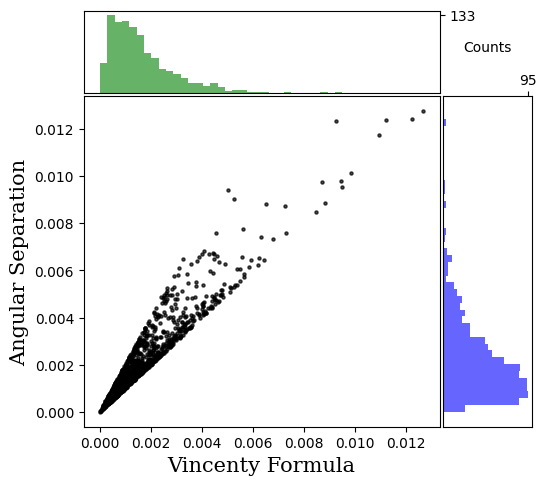

In [9]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
print("Great Circle Distance computation\n")
theta_GC = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error}, asarray=True)
print("\nVincenty Distance computation\n")
theta_V = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec}, asarray=True)

grasp.plots.doubleHistScatter(theta_V, theta_GC[0], xlabel='Vincenty Formula', ylabel='Angular Separation')

Correctly imported `minpack.lm`.


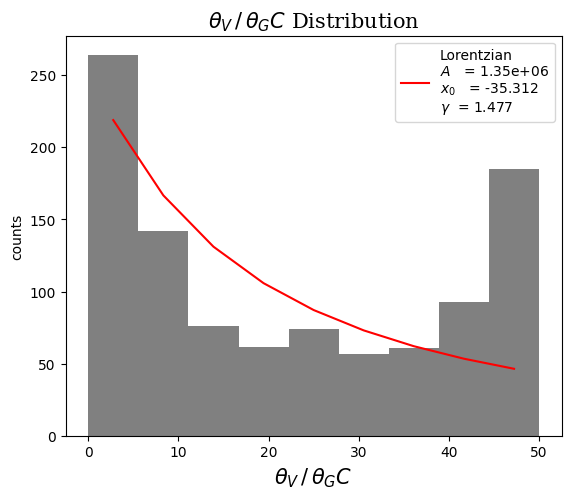

A = 1350986.42  ;  lambda = -35.31


In [10]:
t_ratio = theta_V/theta_GC[0]
err_t = (1-t_ratio) * 100
out = grasp.plots.histogram(err_t, bins='knuth', kde=True, kde_kind='lorentzian', xlabel=r'$\theta_V\,/\,\theta_GC$', out=True)
fit = out['kde']
print(f"A = {fit[0]:.2f}  ;  lambda = {fit[1]:.2f}")

### ADQL computed Angular Separation : $\theta_{G}$

Validated! <br>
It is shown how the angular separation computed from the ADQL language corresponds to the
Great Circle formula used by the GRASP package.

In [11]:
query1: str = "SELECT source_id, DISTANCE(245.897,-26.526, ra, dec) AS ang_sep \
    FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
    AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
    AND abs(parallax_error/parallax)<0.50\
    AND abs(pmra_error/pmra)<0.30 \
    AND abs(pmdec_error/pmdec)<0.30 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0 \
    AND pmra BETWEEN -13.742720 AND -11.295338 \
    AND pmdec BETWEEN -20.214805 AND -17.807517"

query2: str = "SELECT source_id, DISTANCE(245.897,-26.526, ra, dec) AS ang_sep  \
    FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
    AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
    AND ruwe < 1.15 \
    AND phot_g_mean_mag > 11 \
    AND astrometric_excess_noise_sig < 2 \
    AND pmra BETWEEN -13.742720 AND -11.295338 \
    AND pmdec BETWEEN -20.2148 AND -17.807517"

acs2 = grasp.Sample(dr3.free_query(query1), gc='ngc6121')
pcs2 = grasp.Sample(dr3.free_query(query2), gc='ngc6121')

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [12]:
aps2 = acs2.join(pcs2)
aps2.gc.dist = 1851 * u.pc
aps2.info()

<Sample length=1014>
   name    dtype 
--------- -------
SOURCE_ID   int64
  ang_sep float64


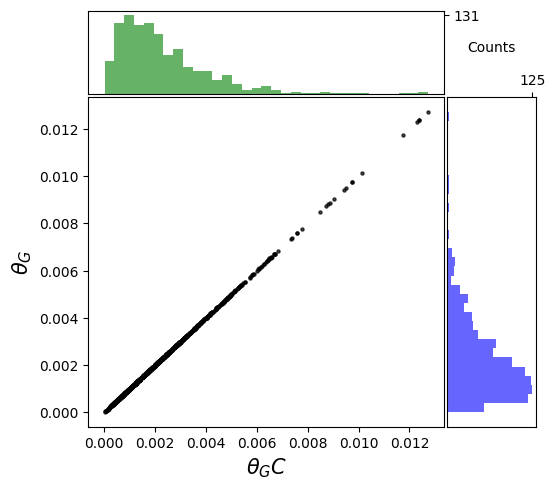

In [13]:
theta_G = (aps2.ang_sep*u.deg).to(u.rad).value
grasp.plots.doubleHistScatter(theta_GC[0], theta_G, bins='knuth', xlabel=r"$\theta_GC$", ylabel=r"$\theta_G$")

### $r_{2D}(\theta_V)$ vs $r_{2D}(\theta_{GC})$

In [14]:
f.substitute('radial_distance_2d', {'r_{c}': aps.gc.dist.value})
f.radial_distance_2d

Eq(r_{2}, 1851.0*tan(theta))

In [15]:
f.var_order('radial_distance_2d')


`Radial distance 2d' variables must be passed in the following order:
Data         : [theta]
Errors       : [epsilon_theta]
Correlations : None


In [16]:
print(r'Computation using $\theta_{GC}$')
r2d_GC = f.compute('radial_distance_2d', data={'theta': theta_GC[0]}, errors = {'epsilon_theta': theta_GC[1]}, asarray=True) # Great Circle
print('')
print(r'Computation using $\theta_{V}$')
r2d_V = f.compute('radial_distance_2d', data={'theta': theta_V}, asarray=True) # Vincenty Formula

r_ratio = r2d_V/r2d_GC[0]

Computation using $\theta_{GC}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Errors:       [epsilon_theta]
Correlations: None
------------------------------
Errors:
Computation using all 16 cores.
Computation using all 16 cores.

Computation using $\theta_{V}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 16 cores.


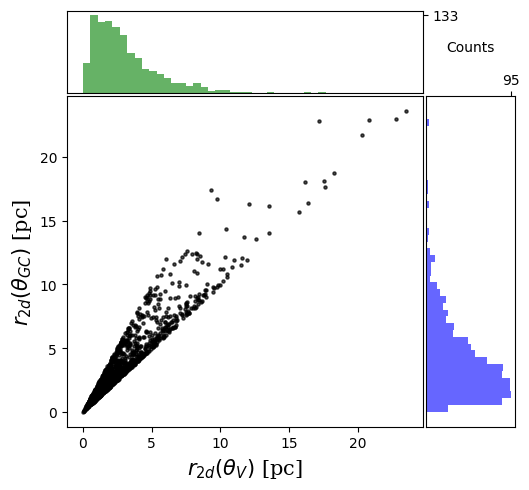

In [17]:
grasp.plots.doubleHistScatter(r2d_V, r2d_GC[0], xlabel=r'$r_{2d}(\theta_{V})$ [pc]', ylabel=r'$r_{2d}(\theta_{GC})$ [pc]')

Correctly imported `minpack.lm`.


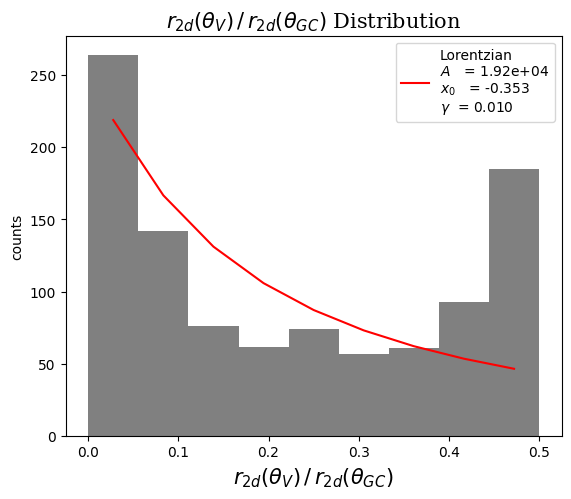

In [18]:
grasp.plots.histogram(1-r_ratio[r_ratio<400], kde=True, kde_kind='lorentzian', xlabel=r'$r_{2d}(\theta_{V})\,/\,r_{2d}(\theta_{GC})$')

# Radial Distance $R$

### Computing $d$ and $r_x$

In [19]:
f.los_distance

Eq(r_{x}, 1/omega)

In [20]:
f.gc_z_coordinate


Eq(d, -r_{c} + r_{x})

In [21]:
f.radial_distance_3d

Eq(R, sqrt(d**2 + r_{2}**2))

In [22]:
rt_pc = np.tan(aps.gc.rt.to(u.rad).value) * aps.gc.dist.to(u.pc)
print(f"Tidal radius of {aps.gc.id} = {rt_pc:.2f}")

Tidal radius of NGC6121 = 27.90 pc


In [23]:
f.var_order('los_distance')
f.var_order('gc_z_coordinate')
f.substitute('gc_z_coordinate', {'r_{c}': aps.gc.dist.value})
print('')
r_x = f.compute('los_distance', data={'omega': aps.parallax}, errors={"epsilon_omega": aps.parallax_error}, asarray=True) * 1000
print('')
d = f.compute('gc_z_coordinate',data={'r_{x}': r_x[0]}, errors={'epsilon_r_{x}': r_x[1]}, asarray=True)


`Los distance' variables must be passed in the following order:
Data         : [omega]
Errors       : [epsilon_omega]
Correlations : None

`Gc z coordinate' variables must be passed in the following order:
Data         : [r_{c}, r_{x}]
Errors       : [epsilon_r_{c}, epsilon_r_{x}]
Correlations : [rho_r_{c}_r_{x}]

WARNING! Be sure that the input data follow this specific order: 
Data:         [omega]
Errors:       [epsilon_omega]
Correlations: None
------------------------------
Errors:
Computation using all 16 cores.
Computation using all 16 cores.

WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{x}]
Errors:       [epsilon_r_{x}]
Correlations: None
------------------------------
Errors:
Computation using all 16 cores.
Computation using all 16 cores.


### $R(\theta_{GC}$)

In [24]:
f.var_order('radial_distance_3d')


`Radial distance 3d' variables must be passed in the following order:
Data         : [d, r_{2}]
Errors       : [epsilon_d, epsilon_r_{2}]
Correlations : [rho_d_r_{2}]


WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Errors:       [epsilon_d, epsilon_r_{2}]
Correlations: [rho_d_r_{2}]
------------------------------
Errors:
Computation using all 16 cores.
Correctly imported `minpack.lm`.


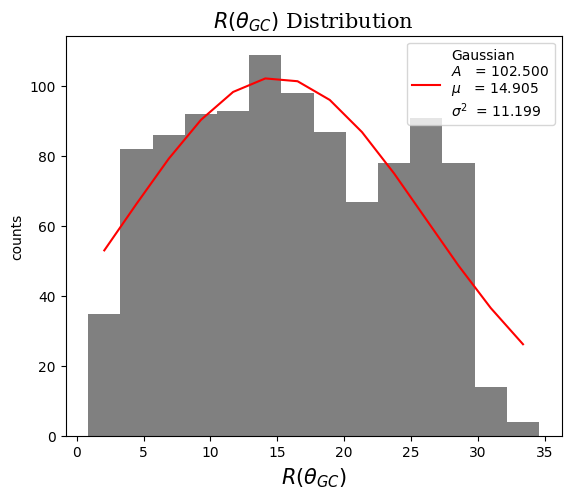

In [25]:
R_GC = f.compute('radial_distance_3d', {'d': d[0],'r_{2}': r2d_GC[0]}, errors={"epsilon_d": d[1], "epsilon_r_{2}": r2d_GC[1]}, asarray=True)
rgc_hist = grasp.plots.histogram(R_GC[0], xlabel=r'$R(\theta_{GC})$', kde=True, kde_kind='gaussian', out=True, kde_verbose=False)

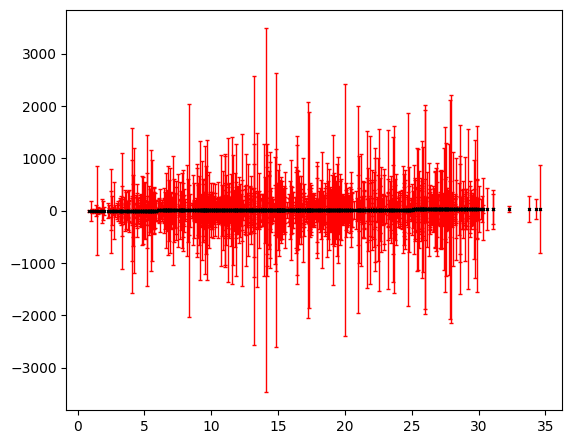

In [26]:
grasp.plots.errorbar(R_GC[0], dataerr=R_GC[1], x=R_GC[0])

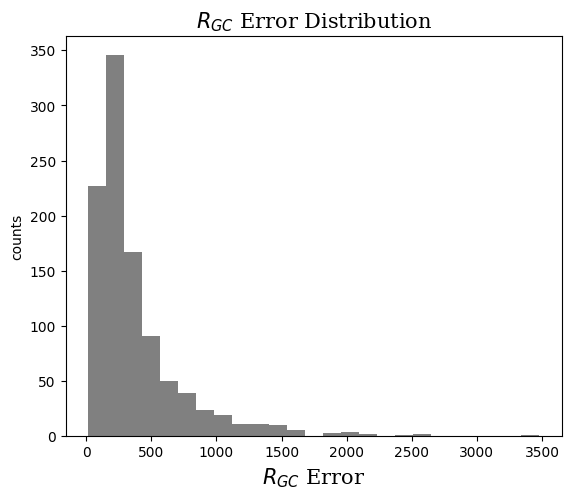

In [27]:
grasp.plots.histogram(R_GC[1], xlabel=r"$R_{GC}$ Error", bins='knuth')

**Conclusions**

The vincenty formula computes the angular separation between two points on an ellipsoid, so, in the case of computing<br>
angular separations between stars in the celestial sphere, which geometry is, effectively, a unit sphere, the Great Circle<br>
formula is the correct one to use, as it computes the distances on a spheric geometry<br>

*Overall*, defined the ratio 

> $\bar{r} = \dfrac{R(\theta_{V})}{R(\theta_{GC})}$

its mean and standard deviation

> $\big<\bar{r}\big> = 0.96$

> $\sigma(\bar{r}) = 0.08$

indicates that, for the problem at hand, the two equations provide almost equal results, provided some outlier data.

In the end, using the GC formula is recommended, as it is computed on the actual geometry we are considering

# Dynamics 

### PMRA ($\mu_\alpha$) mean

Correctly imported `minpack.lm`.


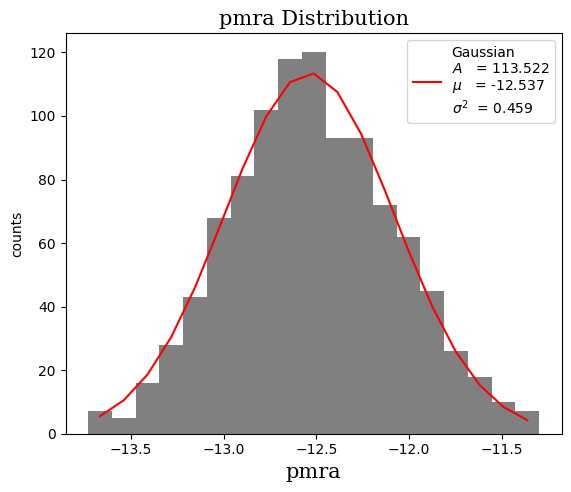

pmra_mean = -12.5372


In [60]:
pmra = aps.pmra
pmra_kde = grasp.plots.histogram(pmra, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmra_mean = pmra_kde[1]
print(f"{pmra_mean = :.4f}")

### PMDEC ($\mu_{\delta^*}$) mean

Correctly imported `minpack.lm`.


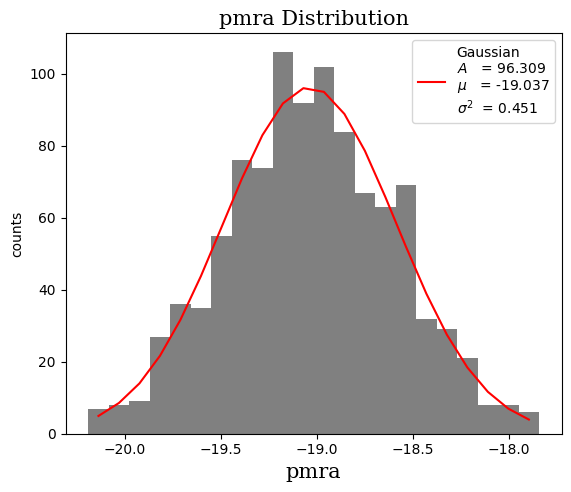

pmdec_mean = -19.0371


In [61]:
pmdec = aps.pmdec
pmdec_kde = grasp.plots.histogram(pmdec, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmdec_mean = pmdec_kde[1]
print(f"{pmdec_mean = :.4f}")

## Gaussian Mixture Model attempt

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as ac, mean_absolute_error as mea, mean_squared_error as mse

data = np.array([aps.SOURCE_ID, aps.pmra, aps.pmdec, theta_GC[0]]).T
errors = np.array([aps.SOURCE_ID, aps.pmra_error, aps.pmdec_error, theta_GC[1]]).T
correlation = aps.pmra_pmdec_corr.value

In [42]:
X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2, random_state=5)
if all(X_train[:,0] == err_train[:,0]) and all(X_test[:,0] == err_test[:,0]):
    print("Data and errors are aligned.\nRemoving source_id column...\n")
    err_train = np.delete(err_train, 0, axis=1)
    err_test = np.delete(err_test, 0, axis=1)
    X_train = np.delete(X_train, 0, axis=1)
    X_test = np.delete(X_test, 0, axis=1)
else:
    print("Data and errors are not aligned. Exiting...")
    exit(1)
print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
print(f"{X_err_train.shape = :}")
print(f"{X_err_test.shape = :}")
print(f"\n{corr_train.shape = :}")
print(f"{corr_test.shape = :}\n")

Data and errors are aligned.
Removing source_id column...

X_train.shape = (811, 3)
X_test.shape = (203, 3)

X_err_train.shape = (811, 3)
X_err_test.shape = (203, 3)

corr_train.shape = (811,)
corr_test.shape = (203,)



In [32]:
train_cov = grasp.stats._construct_covariance_matrices(X_err_train, {(0,1): corr_train})
test_cov = grasp.stats._construct_covariance_matrices(X_err_test, {(0,1): corr_test})
print(f"{train_cov.shape = :}")
print(f"{test_cov.shape = :}\n")

train_cov.shape = (811, 3, 3)
test_cov.shape = (203, 3, 3)



In [33]:
n_components = [1]

logLs: list[float] = []
t_logLs: list[float] = []
for n in n_components:
    print(f"Number of components: {n}", end=' ', flush=True)
    M = grasp.stats.XDGMM(n_components=n, max_iter=100*n, tol=1e-6)
    M.fit(X_train, train_cov)
    logLs.append(M.logL(X_train, train_cov))
    M.logprob_a(X_test, test_cov)
    t_logLs.append(M.logL(X_test, test_cov))


Number of components: 1 

In [43]:
print(X_train.shape, err_train.shape, corr_train.shape)

(811, 3) (811, 3) (811,)


In [44]:
model = grasp.stats.XD_estimator(data=X_train, errors=err_train, correlations={(0,1): corr_train}, n_components=1)

In [62]:
xdgmm_pmra_mean, xdgmm_pmdec_mean, _ = tuple([mu[0] for mu in model.mu.T])
print(f"{pmra_mean = :.3f} mas/yr\n{pmdec_mean = :.3f} mas/yr")

pmra_mean = -12.537 mas/yr
pmdec_mean = -19.037 mas/yr


In [69]:
print(f"{xdgmm_pmra_mean/pmra_mean*100 = :.3f} %")
print(f"{xdgmm_pmdec_mean/pmdec_mean*100 = :.3f} %")

xdgmm_pmra_mean/pmra_mean*100 = 99.962 %
xdgmm_pmdec_mean/pmdec_mean*100 = 99.966 %


## Computation on Full Astrometric Samnple

In [ ]:
fas = dr3.free_gc_query(
    1.,
    'ngc6121', 
    data = 'source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error,ra_dec_corr,pmra_pmdec_corr',
    save=True
)
Ni = len(fas)
fas.join(aps, keep='left_only', inplace=True)
Nf = len(fas)
assert Ni-Nf == len(aps), f"Number of sources in fas ({Ni-Nf}) is not equal to the number of sources in aps ({len(aps)})"

In [ ]:
fas_df = fas.to_pandas(index='SOURCE_ID')

In [ ]:
fas_df.drop(columns=['radial_velocity', 'radial_velocity_error', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_rp_excess_factor', 'teff_gspphot', 'phot_bp_mean_mag', 'phot_rp_mean_mag'], axis=1, inplace=True)

In [ ]:
fas_df.info()

In [ ]:
#f.var_order('angular separation')
fas_df['ang_sep'], fas_df['ang_sep_error'] = f.compute('angular separation',
          data={'alpha_{1}': (fas.ra*u.deg).to(u.rad).value, 'delta_{1}': (fas.dec*u.deg).to(u.rad).value}, 
          errors={"epsilon_alpha_{1}": (fas.ra_error*u.deg).to(u.rad).value, "epsilon_delta_{1}": (fas.dec_error*u.deg).to(u.rad).value}, 
          corrs={'rho_alpha_{1}_delta_{1}': fas.ra_dec_corr},
          asarray=True)

In [ ]:
fas_df[['ang_sep', 'ang_sep_error']].info()

In [ ]:
data = np.array([aps.SOURCE_ID, aps.pmra, aps.pmdec, theta_GC[0]]).T
errors = np.array([aps.SOURCE_ID, aps.pmra_error, aps.pmdec_error, theta_GC[1]]).T
correlation = aps.pmra_pmdec_corr.value

X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2, random_state=5)

if all(X_train[:,0] == err_train[:,0]) and all(X_test[:,0] == err_test[:,0]):
    print("Data and errors are aligned.\nRemoving source_id column...\n")
    X_err_train = np.delete(err_train, 0, axis=1)
    X_err_test = np.delete(err_test, 0, axis=1)
    X_train = np.delete(X_train, 0, axis=1)
    X_test = np.delete(X_test, 0, axis=1)
else:
    print("Data and errors are not aligned. Exiting...")
    exit(1)

print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
print(f"{X_err_train.shape = :}")
print(f"{X_err_test.shape = :}")
print(f"\n{corr_train.shape = :}")
print(f"{corr_test.shape = :}\n")